<a href="https://colab.research.google.com/github/cisprague/bts-2021/blob/main/bts-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System identification of AUVs with physics-informed learning

Christopher Iliffe Sprague (sprague@kth.se)

Sriharsha Bhat (svbhat@kth.se)

# Outline

- Background
- What's the benefit?
- Data generation
- Model identification
- Simulation
- Discussion and future work

# Resources

In [3]:
# JAX for autograd and and numerics
! pip install --upgrade pip
! pip install --upgrade "jax[cuda101]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
import jax.numpy as np
from jax import jit, vmap, jacobian, hessian, grad
from jax.experimental.ode import odeint
from jax.random import uniform, choice
from jax.nn import softplus
from jax.lax import stop_gradient

# Haiku for neural networks
! pip install git+https://github.com/deepmind/dm-haiku
import haiku as hk

# Optax for optimisation
! pip install git+https://github.com/deepmind/optax
import optax

# TQDM for training loop feedback
! pip install tqdm
from tqdm.notebook import tqdm

# SKLearn for preprocessing data
from sklearn.preprocessing import StandardScaler

# treating some arguments as static
from functools import partial

# computer algebra
import sympy

# matplotlib for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-xamusq1m
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-xamusq1m
  Resolved https://github.com/deepmind/dm-haiku to commit 2e90d5deefea23e807c7e55e7cedd0a9a56e83b6
  Cloning https://github.com/deepmind/optax to /tmp/pip-req-build-q98n0qz0
  Running command git clone -q https://github.com/deepmind/optax /tmp/pip-req-build-q98n0qz0
  Resolved https://github.com/deepmind/optax to commit 91937fa03b7edf396b8af9e8b8cc6bfd95160731
     |████████████████████████████████| 57 kB 2.9 MB/s 
  Created wheel for optax: filename=optax-0.0.9-py3-none-any.whl size=120484 sha256=cdd5b35e2fe3de6bfc3e5b8cd324423411b8841be195a70591ce1307e0acff0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-14z5a1hh/wheels/18/80/7e/f95870d651357f77f2ddeb452b3584a09053c224cc08d7fd86
Successfully built optax


In [34]:
# to make sure we're
from jax.lib import xla_bridge
print('We are using the {}'.format(xla_bridge.get_backend().platform))

We are using the gpu


In [35]:
# this is a random seed generator: use `next(key)` to get a seed.
key = hk.PRNGSequence(42)

# Models

## Properties

In [36]:
# dimensions
dim_state = 12
#dim_control = 6 #with rpm1,rpm2,de,dr,vbs,lcg
dim_control = 4 #with rpm1,rpm2,de,dr,vbs,lcg

In [37]:
# state and control bounds: used for generating random dynamics data.
bounds_state = (
    np.array([-20, -20, -20, 0, 0, 0, -10, -10, -10, -10, -10, -10]),
    np.array([20, 20, 20, 2*np.pi, 2*np.pi, 2*np.pi, 10, 10, 10, 10, 10, 10])
)
bounds_control = (
    np.full(dim_control, -1.0),
    np.full(dim_control, 1.0)
)

In [38]:
# random state and control
state = uniform(
    next(key),
    (dim_state,),
    minval=bounds_state[0],
    maxval=bounds_state[1]
)
control = uniform(
    next(key),
    (dim_control,),
    minval=bounds_control[0],
    maxval=bounds_control[1]
)
state, control

(DeviceArray([-10.444722  ,  18.622414  ,  -6.163068  ,   4.124211  ,
                1.41309   ,   5.0011864 ,   5.3415127 ,   0.04921722,
                1.7980938 ,   7.241802  ,  -9.206619  ,  -9.593658  ],            dtype=float32),
 DeviceArray([ 0.5028832 , -0.09884787,  0.6562114 , -0.2787211 ], dtype=float32))

## Transformations

In [39]:
# skew matrix of vector
@jit
def skew(vec):
  return np.array([
    [0, -vec[2], vec[1]],
    [vec[2], 0, -vec[0]],
    [-vec[1], vec[0], 0]
  ])

In [40]:
# vector from skew matrix
@jit
def unskew(mat):
    return np.array([
        mat[2,1],
        mat[0,2],
        mat[1,0]
    ])

In [41]:
# rotation matrix from body to NED for linear vectors
@jit
def R_b2ned(phi, theta, psi):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    Ry = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    Rz = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])
    R = Rz@Ry@Rx
    return R

In [42]:
# rotation matrix from body to NED for angular vectors
@jit
def T_b2ned(phi, theta, psi):
    T = np.array([
        [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
    ])
    return T

We will assume that we know the analytical mapping between $q$ and $\dot q$.

# Analytical model
We will gather data from an analytical model of an AUV, so that we can compare the learned/identified model with a ground truth. However, in practice, one can also use other data as input, such as AUV pose data from missions.

A six degree-of freedom AUV model is used leading to 12 states ($x,y,z,\phi,\theta,\psi,u,v,w,p,q,r $), based on Fossen's notation. 

The kinematics are of the form
    $\dot \eta = J_{euler}(\eta)\nu$ , 
    where $\eta$ represents the vector of positions and orientations in Euler angles, while $\nu$ represents the vector of velocities and angular velocities and $J_{euler}\in\mathbb{R}^{6 \times 6}$ is the kinematic transformation matrix. 

The dynamics are of the form
    $M_{\text{eff}} \dot\nu + C_{\text{eff}}(\nu) + g(\eta) = \tau_C$, 
    where M represents the combined mass and inertia matrix (considering rigid body terms, but added mass terms can also be included), C is the combined coriolis-centripetal matrix, D is the damping matrix (considering hydrodynamics), g represents the buoyancy forces (considering hydrostatics) and $\tau_C$ refers to the vector of external control forces (such as from actuators).

The AUV under consideration (SAM) has 6 actuators including counter-rotating propellers (to control speed and roll), thrust vectoring(for yaw and pitch), longitudinal center of gravity(for static pitching and gliding) and a variable buoyancy system (to regulate buoyancy) and is underactuated. The effect of these actuators are included in the code below.


In [43]:
@jit
def f_analytical(state, control):

  # state and control
  x, y, z, phi, theta, psi, u, v, w, p, q, r = state
  #rpm1, rpm2, de, dr, lcg, vbs = control
  rpm1, rpm2, de, dr = control


  # position (NED) and velocity (body), rsp
  eta = np.array([x, y, z, phi, theta, psi])
  nu = np.array([u, v, w, p, q, r])

  # scaled controls
  rpm1 *= 1000.0
  rpm2 *= 1000.0
  de *= 0.05
  dr *= 0.05
  # vbs *= 1.0
  # lcg *= 1.0

  # mass and inertia matrix
  m = 14.0
  I_o = np.diag(np.array([0.0294, 1.6202, 1.6202]))

  # centre of gravity, buoyancy, and pressure positions, resp.
  #r_g = np.array([0.1 + lcg*0.01, 0.0, 0.0])
  r_g = np.array([0.1, 0.0, 0.0]) #no effect of Longitudinal C.G. trim system
  r_b = np.array([0.1, 0.0, 0.0])
  r_cp = np.array([0.1, 0.0, 0.0])

  # <insert title>
  W = m*9.81
  #B = W + vbs*1.5
  B = W #no effect of Variable buoyancy system


  # hydrodynamic coefficients
  Xuu = 5. #3. #1.0
  Yvv = 20. #10. #100.0
  Zww = 50. #100.0
  Kpp = 0.1 #10.0
  Mqq = 20.#40 #100.0
  Nrr = 20. #150.0

  # control actuators
  K_T = np.array([0.0175, 0.0175])
  Q_T = np.array([0.001, -0.001])#*0.0

  # mass and inertia matrix
  M = np.block([
    [m*np.eye(3,3), -m*skew(r_g)],
    [m*skew(r_g), I_o]
  ])
  assert M.shape == (6,6), M

  # coriolis and centripetal matrix
  nu1 = np.array([u, v, w])
  nu2 = np.array([p, q, r])
  top_right = -m*skew(nu1) - m*skew(nu2)*skew(r_g)
  bottom_left = -m*skew(nu1) + m*skew(r_g)*skew(nu2)
  bottom_right = -skew(I_o.dot(nu2))
  C_RB = np.block([
    [np.zeros((3,3)), top_right],
    [bottom_left, bottom_right]
  ])
  assert C_RB.shape == (6, 6), C_RB

  # damping matrix
  forces = np.diag(np.array([Xuu*np.abs(u), Yvv*np.abs(v), Zww*np.abs(w)]))
  moments = np.diag(np.array([Kpp*np.abs(p), Mqq*np.abs(q), Nrr*np.abs(r)]))
  coupling = np.matmul(skew(r_cp), forces)
  D = np.block([[forces, np.zeros((3, 3))], [-coupling, moments]])
  assert D.shape == (6, 6), D

  # rotational transform between body and NED in Euler
  T_euler = T_b2ned(phi, theta, psi)      
  R_euler = R_b2ned(phi, theta, psi)
  assert R_euler.shape == (3,3), R_euler
  J_eta = np.block([
    [R_euler, np.zeros((3,3))],
    [np.zeros((3,3)), T_euler]
  ])
  assert J_eta.shape == (6,6), J_eta

  # buoyancy in quaternions
  f_g = np.array([0, 0, W])
  f_b = np.array([0, 0, -B])
  row1 = np.linalg.inv(R_euler).dot(f_g + f_b)
  row2 = skew(r_g).dot(np.linalg.inv(R_euler)).dot(f_g) + \
    skew(r_b).dot(np.linalg.inv(R_euler)).dot(f_b)
  geta = np.block([row1, row2])
  assert geta.shape == (6,), geta

  # <insert title>
  F_T = K_T.dot(np.array([rpm1, rpm2]))
  M_T = Q_T.dot(np.array([rpm1, rpm2]))
  tauc = np.array([
    F_T*np.cos(de)*np.cos(dr),
    -F_T*np.sin(dr),
    F_T*np.sin(de)*np.cos(dr),
    M_T*np.cos(de)*np.cos(dr),
    -M_T*np.sin(dr),
    M_T*np.sin(de)*np.cos(dr)
  ])
  assert tauc.shape == (6,), tauc

  # velocity and acceleration 
  etadot = np.block([J_eta.dot(nu)])
  assert etadot.shape == (6,)
  nudot = np.linalg.inv(M).dot(tauc - (C_RB + D).dot(nu) - geta)
  #F_nonconsv = tauc - D.dot(nu) # nonconservative terms 
  #F_consv = -C_RB.dot(nu)-geta # conservative terms in the nudot equation  
  assert nudot.shape == (6,)

  # state-space
  sdot = np.block([etadot, nudot])
  return sdot

# Machine learning models

We will consider the following learning models:
- Learn a linear model.
- Learn the damping matrix.
- Learn the nonlinear model with a naïve MLP.
- Learn the nonlinear model with a decompositional physics-informed model.

Other things:
- We know a priori that the dynamics of the analytical model is invariant under the position. Thus, we let the models learn from the variable in the body frame, therby making the $p = [0,0,0]$ in regression.
- It is well-known that Euler angle and quaternions are discontinuous representation, and hence troublesome to the regression process. Thus, in ever model, we choose to learn from the rotation matrix, which is a continuous orientation representation.

## Naïve

In [44]:
def F_naive(state, control):

    # position, orientation, velocities
    p, theta, v, omega = state.split(4)

    # linear rotation matrix and its time-derivitive
    R = R_b2ned(*theta)
    Rinv = np.linalg.pinv(R)
    dR = R@skew(omega)

    # angular rotation matrix
    T = T_b2ned(*theta)

    # continuous canonical states
    q = np.hstack(([0,0,0], R.flatten()))
    dq = np.hstack((v, dR.flatten()))

    # ddq from NN
    ddq = hk.nets.MLP(
        [1000, 1000, 1000],
        activation=softplus
    )(np.hstack((q, dq, control)))

    # accelerations in body frame
    a = ddq[0:3]
    ddR = ddq[3:12].reshape((3,3))
    alpha = unskew(Rinv@ddR)

    # dynamics
    dstate = np.hstack((R@v, T@omega, a, alpha))
    return dstate

## Physics-informed

In [45]:
def F_conservative(state):

    # NED position, NED orientation, body velocities
    p, theta, v, omega = state.split(4)

    # rotation matrix and its time-derivitive
    R = R_b2ned(*theta)
    dR = R@skew(omega)

    # canonical 0th and 1st derivative
    q = np.hstack(([0,0,0], R.flatten()))
    dq = np.hstack((v, dR.flatten()))

    # Lagrangian
    L = lambda q, dq: hk.nets.MLP(
        [200, 200, 200, 1], 
        activation=softplus
    )(np.hstack((q, dq)))[0]

    # conservative acceleration
    ddq = jacobian(jacobian(L, 1), 0)(q, dq)
    ddq = ddq @ dq
    ddq = grad(L, 0)(q, dq) - ddq
    ddq = np.linalg.pinv(hessian(L, 1)(q, dq)) @ ddq

    # accelerations in body frame
    a = ddq[0:3]
    ddR = ddq[3:12].reshape((3,3))
    alpha = unskew(np.linalg.pinv(R)@ddR)

    # dynamics
    T = T_b2ned(*theta)
    dstate = np.hstack((R@v, T@omega, a, alpha))
    return dstate

In [46]:
def F_non_conservative(state, control):

    # NED position, NED orientation, body velocities
    p, theta, v, omega = state.split(4)

    # rotation matrix and its time-derivitive
    R = R_b2ned(*theta)
    dR = R@skew(omega)

    # canonical 0th and 1st derivative
    q = np.hstack(([0,0,0], R.flatten()))
    dq = np.hstack((v, dR.flatten()))

    # non-conservative acceleration
    net = hk.nets.MLP([200, 200, 200, 3 + 9], activation=softplus)
    ddq = net(np.hstack((q, dq, control)))

    # accelerations in body frame
    a = ddq[0:3]
    ddR = ddq[3:12].reshape((3,3))
    alpha = unskew(np.linalg.pinv(R)@ddR)

    # dynamics
    T = T_b2ned(*theta)
    dstate = np.hstack((R@v, T@omega, a, alpha))
    return dstate

## Random control policy

In [47]:
def Policy(state):
    net = hk.nets.MLP([500, 500, 500, dim_control], activation=softplus)
    control = np.tanh(net(state))
    return control

# Integration

In [48]:
@partial(jit, static_argnums=(1,2,3))
def trajectory(x, f, T, h):
    return odeint(f, x, np.arange(0.0, T, h))

In [49]:
trajectories = jit(
    vmap(trajectory, in_axes=(0,None,None,None)),
    static_argnums=(1,2,3)
)

# Visualisation

In [50]:
def plot(trajs_list, markers, labels):

    # setup
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot
    for trajs, marker, label in zip(trajs_list, markers, labels):
        for i, traj in enumerate(trajs):
            label = None if i else label
            ax.plot(
                traj[:,0],
                traj[:,1],
                traj[:,2],
                marker,
                label=label
            )

    # format
    plt.legend()
    plt.show()

# Training and loss functions

In [51]:
class Trainer:

    def __init__(self, n):

        # number of data to train on
        self.n = n

        # loss record
        self.losses = list()

    @partial(jit, static_argnums=(0,))
    def f(self, state, control):
        raise NotImplementedError()

    @partial(jit, static_argnums=(0,))
    def gen_data(self, key):

        # generate random states
        states = uniform(
            key,
            shape=(self.n, dim_state),
            minval=bounds_state[0],
            maxval=bounds_state[1]
        )

        # generate random controls
        controls = uniform(
            key,
            shape=(self.n, dim_control),
            minval=bounds_control[0],
            maxval=bounds_control[1]
        )

        # analytical time-derivatives
        dstates = vmap(f_analytical, in_axes=(0,0))(states, controls)
        return states, controls, dstates

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):
        raise NotImplementedError()

    @partial(jit, static_argnums=(0,))
    def grad(self, params, key):
        return grad(self.loss, argnums=0, has_aux=True)(params, key)

    def train(self, epo, lr, algo):

        # setup optimiser
        opt_init, opt_update = algo(lr)
        opt_state = opt_init(self.params)

        # training loop
        pb = tqdm(range(epo))
        for _ in pb:

            # gradient and loss
            gopt, loss = self.grad(self.params, next(key))

            # record loss
            self.losses.append(loss)

            # progress bar update
            pb.set_description('{:.6f}'.format(loss))

            # optimiser update
            updates, opt_state = opt_update(
                gopt, 
                opt_state, 
                self.params
            )

            # update the parameters
            self.params = optax.apply_updates(self.params, updates)

In [52]:
class Trainer_Naive(Trainer):

    def __init__(self, n):

        # inherit
        Trainer.__init__(self, n)

        # naïve model
        self.f_naive = hk.without_apply_rng(hk.transform(F_naive))
        self.params = self.f_naive.init(next(key), state, control)

    @partial(jit, static_argnums=(0,))
    def f(self, state, control):
        return self.f_naive.apply(self.params, state, control)

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):

        # generate data
        states, controls, dstates = self.gen_data(key)

        # predictions
        dstates_nn = vmap(self.f_naive.apply, in_axes=(None,0,0))(params, states, controls)

        # loss
        loss = dstates[:,6:] - dstates_nn[:,6:]
        loss = np.average(np.square(loss))
        # loss = np.linalg.norm(loss, ord=2, axis=1)
        # loss = np.sum(loss)/(self.n*6)
        # loss = loss**0.5
        return loss, loss

In [53]:
class Trainer_Decomposition(Trainer):

    def __init__(self, n, l):

        # inherit
        Trainer.__init__(self, n)

        # conservative and non-conservative models
        self.f_c = hk.without_apply_rng(hk.transform(F_conservative))
        self.f_nc = hk.without_apply_rng(hk.transform(F_non_conservative))

        # models' parameters
        self.params = (
            self.f_c.init(next(key), state),
            self.f_nc.init(next(key), state, control)
        )

        # non-conservative penalization
        self.l = l

    @partial(jit, static_argnums=(0,))
    def f(self, state, control):
        dstate = self.f_c.apply(self.params[0], state)
        dstate += self.f_nc.apply(self.params[1], state, control)
        return dstate

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):

        # generate data
        states, controls, dstates = self.gen_data(key)

        # predictions
        dstates_c = vmap(self.f_c.apply, in_axes=(None,0))(params[0], states)
        dstates_nc = vmap(self.f_nc.apply, in_axes=(None,0,0))(params[1], states, controls)
        dstates_nn = dstates_c + dstates_nc

        # loss for dynamics
        loss_f = dstates[:,6:] - dstates_nn[:,6:]
        loss_f = np.mean(np.square(loss_f))
        # loss_f = np.linalg.norm(loss_f, ord=2, axis=1)
        # loss_f = np.sum(loss_f)/(self.n*6)
        # loss_f = loss_f**0.5

        # loss for non-conservative
        loss_nc = dstates_nc[:,6:]
        loss_nc = np.mean(np.square(loss_nc))
        # loss_nc = np.linalg.norm(dstates_nc[:,6:], ord=2, axis=1)
        # loss_nc = np.sum(loss_nc)/(self.n*6)
        # loss_nc = loss_nc**0.5

        # total loss
        loss = loss_f + self.l*loss_nc
        return loss, loss

# Results

In [54]:
trainer = Trainer_Naive(1000)

In [ ]:
trainer.train(10000, 1e-2, optax.adam)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
np.save('nn.npy', trainer.params)

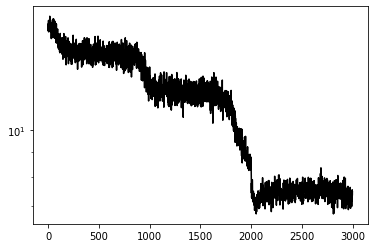

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(trainer.losses, 'k-')
ax.set_yscale('log')
plt.show()

In [ ]:
trajs_list = [
    trajectories(
        states,
        # lambda x, t: f_analytical(x, policy.apply(params_policy, x)),
        lambda x, t: f_analytical(x, np.ones((dim_control,))),
        10.0,
        0.01
    ),
    trajectories(
        states,
        # lambda x, t: trainer.f_nn.apply(trainer.params, x, policy.apply(params_policy, x)),
        lambda x, t: trainer.f_nn.apply(trainer.params, x, np.ones((dim_control,))),
        10.0,
        0.01
    )
]

NameError: name 'states' is not defined

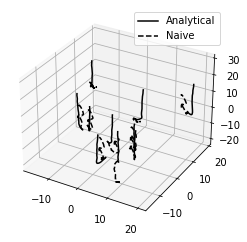

In [ ]:
plot(trajs_list, ['k-', 'k--'], ['Analytical', 'Naive'])